# CS 136 day09: MAP estimation for Logistic Regression

## Takeaways

* First-order methods are cheap but require many iterations
* Second-order methods are awesome, but still require careful step-size selection
* For all gradient descent methods, selecting step sizes is super important. Line search is needed!

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

from scipy.special import expit as sigmoid

In [2]:
np.set_printoptions(precision=3, suppress=False)

In [3]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Creating a simple toy data for analysis

In [5]:
N = 10  # Number of examples we observe
M = 2     # Number of transformed features

Create the weight vector we'll use to generate our dataset. Set an intercept of 1.2 and a slope of -0.75

In [6]:
true_w_M = np.asarray([0.1, -0.25])

Create a "true" alpha value which controls the prior precision

In [7]:
true_alpha = 0.01

Create observed features $x$ and observed outputs $t$ manually

In [8]:
def calc_features(x_N1, M=2):
    ''' Transform raw features into complete features useful for prediction
    
    Could do any non-linear transformations thought relevant for the problem.
    Here we'll just do an identity transform with an extra intercept feature.
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1) = (n_examples,)
    
    Returns
    -------
    phi_NM : 2D array, shape (N, M) = (n_examples, n_transformed_features)
        First column will contain all ones (a bias or intercept feature)
        Second column will just include the raw features
    '''
    assert x_N1.ndim == 2
    assert x_N1.shape[1] == 1
    N = x_N1.shape[0]
    phi_NM = np.zeros((N, M))
    phi_NM[:,0] = 1
    phi_NM[:,1] = x_N1[:,0]
    return phi_NM

x_N1 = np.asarray([-5, -0.8, -0.7, -0.6, -0.4, 0.5, 0.8, 0.9, 4.3, 4.1]).reshape((N, 1))
phi_NM = calc_features(x_N1)

In [9]:
prng = np.random.RandomState(101) # reproducible random seed

In [10]:
t_N = (prng.rand(N) < sigmoid(np.dot(phi_NM, true_w_M))).astype(np.float64)

# A bunch of helper functions

In [11]:
def calc_sum_of_log_bern_pmf(t_N, p_N):
    ''' Calculate the log of the bernoulli pmf for N observations
    
    Args
    ----
    t_N : 1D array, shape (N,)
        Binary value (0 or 1) for each example n
    p_N : 1D array, shape (N,)
        Probability parameter of the Bernoulli for each example n
        
    Returns
    -------
    summed_logpmf : scalar float
        Summed log PMF over all N examples given
    '''
    # Make sure provided probabilities are not hard 0 or hard 1
    # so that the log values will not be numerically bad
    safe_p_N = np.minimum(np.maximum(p_N, 1e-100), 1 - 1e-13)
    return np.sum(np.log(safe_p_N)[t_N==1]) + np.sum(np.log(1-safe_p_N)[t_N==0])

In [12]:
def calc_loss(wguess_M, phi_NM, t_N, alpha=0.1):
    ''' Compute the negative log prior plus negative log likelihood
    
    Args
    ----
    w_M : 1D array, shape (M,)
        Weight parameter at which we want to evaluate the MAP objective
    phi_NM : 2D array, shape (N,M)
        Each row is a feature vector for one example
    t_N : 1D array, shape (N,)
        Each row is a output scalar value for one example
    alpha : positive scalar
        Prior precision
    
    Returns
    -------
    
    '''
    log_prior_pdf = scipy.stats.multivariate_normal.logpdf(wguess_M, np.zeros(M), 1.0/alpha * np.eye(M)) 
    log_lik_pdf = calc_sum_of_log_bern_pmf(t_N, sigmoid(np.dot(phi_NM, wguess_M)))
    
    return -1 * log_prior_pdf + -1 * log_lik_pdf

In [13]:
def calc_R(w_M, phi_NM):
    s_N = np.dot(phi_NM, w_M)
    R_NN = np.diag( sigmoid(s_N) * sigmoid(-s_N) )
    return R_NN

In [14]:
def calc_gradient_of_map_loss(w_M, phi_NM, t_N, alpha):
    ''' Calculate the gradient.
    
    Returns
    -------
    g_M : 1D array, shape (M,)
        Gradient vector evaluated at current weights w
    '''
    # Compute predicted probability of positive class
    yproba_N = sigmoid( np.dot(phi_NM, w_M) )
    return np.dot(phi_NM.T, (yproba_N - t_N)) + alpha * w_M

In [15]:
def calc_hessian_of_map_loss(w_M, phi_NM, t_N, alpha):
    ''' Calculate the Hessian.
    
    Returns
    -------
    H_MM : 2D array, shape (M,M)
        Hessian matrix evaluated at current weights w
    '''
    R_NN = calc_R(w_M, phi_NM)
    return np.dot(phi_NM.T, np.dot(R_NN, phi_NM)) + alpha * np.eye(M)

## First-order gradient descent

In [16]:
def first_order_gradient_descent( step_size , max_n_steps ):

    w_M = 1.5 * np.ones(M)

    GD1_history_of_w = [w_M]
    GD1_history_of_loss = [calc_loss(w_M, phi_NM, t_N, true_alpha)]

    for step in range(max_n_steps):

        # Compute gradient
        g_M = calc_gradient_of_map_loss(w_M, phi_NM, t_N, true_alpha)

        # Update the weights by taking a step downhill
        w_M = w_M - step_size * g_M

        # Print out progress
        cur_loss = calc_loss(w_M, phi_NM, t_N, true_alpha)
        print("step %3d/%d  loss %11.4f | gradient_norm %9.4f | intercept %9.3f | slope %9.3f" % (
            step, max_n_steps, cur_loss, np.sum(np.abs(g_M)), w_M[0], w_M[1]))
        GD1_history_of_loss.append(cur_loss)
        GD1_history_of_w.append(w_M)

        if step % 10:
            step_size = 0.95 * step_size  # slowly decay the step size

    bestw_fromGD_M = w_M
    
    return GD1_history_of_w , GD1_history_of_loss

# Second order gradient descent

In [17]:
def second_order_gradient_descent( step_size , max_n_steps ):
    

    w_M = 1.5 * np.ones(M)

    GD2_history_of_w = [w_M]
    GD2_history_of_loss = [calc_loss(w_M, phi_NM, t_N, true_alpha)]

    for step in range(max_n_steps):

        g_M = calc_gradient_of_map_loss(w_M, phi_NM, t_N, true_alpha)
        H_MM = calc_hessian_of_map_loss(w_M, phi_NM, t_N, true_alpha)
        w_M = w_M - step_size * np.linalg.solve(H_MM, g_M) # compute H^1 times g
        cur_loss = calc_loss(w_M, phi_NM, t_N, true_alpha)

        print("step %3d/%d  loss %11.4f | gradient_norm %9.4f | intercept %9.3f | slope %9.3f" % (
            step, max_n_steps, cur_loss, np.sum(np.abs(g_M)), w_M[0], w_M[1]))
        GD2_history_of_loss.append(cur_loss)
        GD2_history_of_w.append(w_M)

        #if step % 10:
        #    step_size = 0.95 * step_size # slowly decay step size
        
    return GD2_history_of_w , GD2_history_of_loss

In [54]:
def plot_results( GD1_history_of_w , GD2_history_of_w ):
    # Create a pretty contour plot over the grid of w[0], w[1], loss values
    whistory_GD1_T2 = np.vstack(GD1_history_of_w)
    whistory_GD2_T2 = np.vstack(GD2_history_of_w)

    # Create a 2-dim grid of possible w values
    
    G = 51 # G possible values for intercept
    w0_grid_G = np.linspace( -3 , 3 , G)

    H = 51 # H possible values for slope
    w1_grid_H = np.linspace( -3 , 3 , H)

    w0_GH, w1_GH = np.meshgrid(w0_grid_G, w1_grid_H,)

    # Compute loss at each possible value in our grid
    loss_GH = np.zeros((G, H))
    for gg in range(G):
        for hh in range(H):
            cur_w_M = np.hstack([w0_GH[gg,hh], w1_GH[gg, hh]])        
            loss_GH[gg, hh] = calc_loss(cur_w_M, phi_NM, t_N, true_alpha)

    levels = np.linspace(0, 40, 51) # 50 evenly spaced levels

    fig_handle, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(8,8));

    ax_handle.contour(w0_GH, w1_GH, loss_GH, levels=levels, linewidths=0, colors='k')
    cntrf_handle = ax_handle.contourf(w0_GH, w1_GH, loss_GH, levels=levels, cmap='RdBu_r', vmin=levels[0], vmax=levels[-1]);

    cbar = plt.colorbar(cntrf_handle, ax=ax_handle)
    cbar.set_label('MAP loss objective (lower is better)', fontsize=16);
    cbar.set_ticks(levels[::10]);

    # Show the first 10 iterates of GD
    ax_handle.plot(whistory_GD1_T2[:1,0], whistory_GD1_T2[:1,1], 'kx', markersize=15, label='Initial w value')
    ax_handle.plot(whistory_GD1_T2[:10,0], whistory_GD1_T2[:10,1], 'ks-', label='First 10 steps of 1st-order GD')
    ax_handle.plot(whistory_GD2_T2[:10,0], whistory_GD2_T2[:10,1], 'ms-', label='First 10 steps of 2st-order GD')

    ax_handle.set_xlim( -3 , 3 )
    ax_handle.set_ylim( -3 , 3 )
    
    plt.xlabel('intercept   $w_1$');
    plt.ylabel('slope   $w_2$');
    plt.gca().set_aspect('equal', 'box');
    plt.ylim([-3, 2]);
    plt.legend(loc='upper left');

# Example Code to Modify

First Order gradient descent:
step   0/10  loss     13.3582 | gradient_norm   12.4385 | intercept     1.231 | slope    -0.719
step   1/10  loss     12.9273 | gradient_norm    2.8867 | intercept     1.098 | slope    -0.275
step   2/10  loss     12.8019 | gradient_norm    2.4277 | intercept     0.878 | slope    -0.516
step   3/10  loss     12.6890 | gradient_norm    1.7594 | intercept     0.815 | slope    -0.262
step   4/10  loss     12.6510 | gradient_norm    1.5637 | intercept     0.708 | slope    -0.423
step   5/10  loss     12.6150 | gradient_norm    1.0530 | intercept     0.683 | slope    -0.278
step   6/10  loss     12.6012 | gradient_norm    0.8692 | intercept     0.634 | slope    -0.363
step   7/10  loss     12.5921 | gradient_norm    0.5274 | intercept     0.620 | slope    -0.299
step   8/10  loss     12.5887 | gradient_norm    0.3724 | intercept     0.599 | slope    -0.330
step   9/10  loss     12.5872 | gradient_norm    0.2076 | intercept     0.590 | slope    -0.311

Second Or

/var/folders/p7/9kd4l_491f5_m_rrz6cw44w80000gq/T/ipykernel_81111/1340406650.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(cntrf_handle, ax=ax_handle)


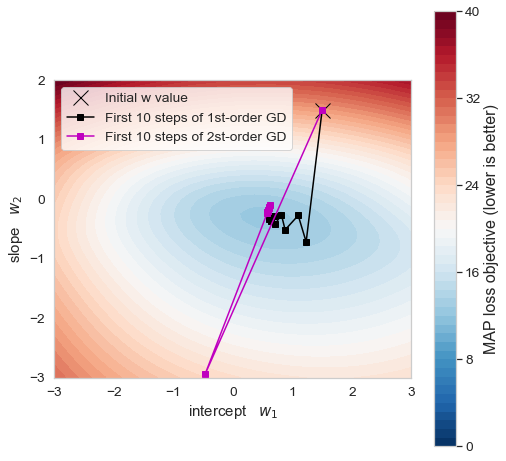

In [55]:
max_n_steps = 10

first_order_step_size = 0.2 # Selected by starting at 1.0, and trying smaller values until first 5 steps made loss better
print( "First Order gradient descent:" )
GD1_history_of_w , GD1_history_of_loss = first_order_gradient_descent( first_order_step_size , max_n_steps )   
    
second_order_step_size = 0.15 # Selected by starting at 1.0, and trying smaller values until first 5 steps made loss better
print( "\nSecond Order gradient descent:" )
GD2_history_of_w , GD2_history_of_loss = second_order_gradient_descent( second_order_step_size , max_n_steps )

plot_results( GD1_history_of_w , GD2_history_of_w )

## Discussion: Compare the *first step* that 1st-order GD took to the *first step* that 2nd-order GD took.

### Note: The step size here has been optimized for each method

* Which is a better *direction*?
* Which ended up closer to the optimal value because of well-chosen step-length?

## Coding: Try the following values of step sizes and compare: 
- 0.5
- 0.1
- 0.05

### Note: These are some other plausible values that may or may not be good.

In [61]:
max_n_steps = 10
step_size = 0.05

print( "First Order gradient descent:" )
GD1_history_of_w , GD1_history_of_loss = first_order_gradient_descent( step_size , max_n_steps )   
    
print( "\nSecond Order gradient descent:" )
GD2_history_of_w , GD2_history_of_loss = second_order_gradient_descent( step_size , max_n_steps )

plot_results( GD1_history_of_w , GD2_history_of_w )

NameError: name 'TODO' is not defined

## Discussion: Compare the overall behavior of 1st and 2nd order GD.... do you see big qualitative differences?

* Which one makes faster progress toward the minimum?
* How are both sensitive to the step-size choice?